# No Pitch is an Island: Pitch Type Prediction Through Sequence-to-Sequence Deep Learning

One of the signature dishes of baseball-related machine learning is pitch prediction, whereby the analysis aims to predict what type of pitch will be thrown next in a game. The strategic advantages of knowing what a pitcher will throw beforehand are obvious due to the lengths teams go (both legal and illegal) to gain such information. Analysts that solve the issue through data have taken various approaches in the past, but here are some commonalities among them:

- Supervised learning is incorporated with numerous variables (batter-handedness, count, inning, etc.) to fit models on training data, which are then used to make predictions on test data.
- The models are fit on a pitcher-by-pitcher basis. That is, algorithms are applied to each pitcher individually to account for their unique tendencies and repertoire. Results are reported as an aggregate of all these individual models.
- There is a minimum cut-off for the number of pitches thrown. In order for a pitcher's work to be considered they must have crossed that threshold.

An example can be found [here](https://www.researchgate.net/publication/319131812_Using_multi-class_classification_methods_to_predict_baseball_pitch_types). The goal of this study is not to reproduce or match those strong results, but to introduce a new, natural-fitting ingredient that can improve on their limitations. The most constraining restriction in other works is the sample size requirement; by only including pitchers with substantial histories the scope of the pitch prediction task is drastically reduced. We hope to produce a model capable of making predictions for all pitchers regardless of their individual sample size.

## The Encoder-Decoder

Every plate appearance is a sequence of pitches. As obvious as it seems to point that out, they are rarely considered as such. Box scores reduce plate appearances to singular events: either a hit or a walk or some funner thing. Even the study linked above treats each pitch as single inputs rather than full sequences of pitches, even though there are variable that consider past pitches. Machine translation, with its sequence-to-sequence prediction structure, offers a deep learning paradigm that more closely mimics the reality of pitching. The objective of that field of study is to convert strings of words to different languages, meaning sequences of words are taken as inputs and then translated to outputs. Basically, one sequence is used to predict another. Given the wealth of data available for every plate appearance in MLB, shouldn't it be possible to appropriate such a design for our own purposes?

Enter the encoder-decoder deep learning model. As the name suggests, there are two parts to this architecture: the encoder and the decoder. The former reads an input sequence and transforms it into a state suitable for being fed to the latter. The decoder then takes the encoded state and outputs a sequence. If the preceding sentences sound like an oversimplification of the model, that's because they are. I won't get bogged down in the gory details of the encoder-decoder here; those interested in diving deeper should do so on their own time. Instead this space will be used to address some issues that are relevant to the pitch type prediction task, as well as specify how the prediction task will be structured.

## Methodology

Every plate appearance of the 2021 regular MLB season was considered as a potential data point for this analysis. The novelty of the approach here will be to predict multiple pitches into the future. Given that inputs must be sequential, only plate appearances that lasted at least three pitches were included. The labels being predicted shall be the final two pitches in the sequence. Or, in other notation: if $N$ represents the number of pitches in a plate appearance, then the sequence 1 through $N-2$ (unless the PA is three pitches, in which case $N-2$ is the first pitch) will predict the pitch types of $N-1$ and $N$. By requiring each PA to be at least three pitches there will be a starting point for each sequence to forecast off. The seasonal data will be split into training and test sets using July 31, 2021 as a cut-off; any plate appearance before that date will be deemed training data and any point after test data. A random portion of the training data (20%) will be taken as a validation set. 

The design of will be set up for multiclass classification. As previously mentioned, a wide variety of pitchers will be incorporated into the data. Since there are wide discrepancies between the repertoires of different pitchers we need to consolidate some pitch types in the MLBAM data. As an example, pitches that are classified as a "Sinker" will be combined to be in the same class as a "Two-Seam Fastball." After performing this re-regrouping we are left with 7 distinct pitch classes. One of the drawbacks of merging all pitchers into one dataset is that the model may predict a type that isn't actually a part of a given pitcher's repertoire. For pitchers with longer histories the deep learning model should naturally learn their tendencies due to the inclusion of a "Pitcher" categorical variable. 

All variables will be treated to match temporal reality. Information a batter would only know in the future cannot be incorporated in the present. There are some variables we can assume are constant for a PA (batter-handedness, pitcher-handedness, etc.), which are taken as input to the decoder. Other variables are only known after the pitch is thrown, such as pitch velocity, and cannot be used similarly. And finally, there is a third category: variables that are known for the first pitch of a sequence but unknown for the remaining parts. An example would be balls and strikes since we know the count for the first pitch we are aiming to forecast, but do not know what the count will be after that. 

Anybody familiar with deep learning knows how finicky models can be when it comes to the shapes of inputs and outputs, as well as the layers in between. That's an important consideration here because, as we know, not all plate appearances have the same number of pitches. By using a technique called masking we can take inputs of variable length and change them to being fixed. For instance, if an input sequence contains only four pitches it can be padded with pre-selected values. This can be repeated so each sequence has the same pre-determined length. See the figure below for a visual representation. Each row represents a pitch, while each column stores data such as velocity or spin rate. The masking value is chosen as -100 and the sequence is padded to a length of 15. Only the final four rows contribute to the updating of weights as the model is run. 

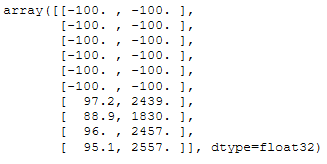

Now that we have a sense of what the pre-processed data will look like, we can discuss some elements of the actual encoder-decoder in this use case. When a model becomes overfit on training data there tends to be significantly poorer performance on new data. The issue popped up in preliminary analysis of the pitch prediction task, so a mechanism known as regularization was employed to handle it. Incorporating L2 regularization and dropout significantly improved performance on validation and test data. Another popular and burgeoning technique in machine translation is the implementation of an attention layer, which is designed to focus on important elements of the sequence. It's fair to assume that some positions in a chain are more crucial than others for the purposes of forecasting. One would think that may also be the case in a pitch sequence as well. 

In order to maximize the predictive power of the classifier, it will be necessary to tune hyper-parameters and, given the limited computational resources available and the power required for running deep learning algorithms, we need an efficient way of doing so. The hyperband algorithm is one solution to the issue. It provides a faster method for tuning by assigning resources to different areas of the model configuration. The tuner will minimize loss on validation data, with the function being categorical cross entropy.  

## Results

A total of 132,562 plate appearances ended up meeting crieria for the 2021 season, 85,927 of which were used for training. An encoder-decoder was constructed in Python using Keras, which is a library built on TensorFlow 2. Ultimately, the encoder consisted of two LSTM layers with L2 regularization, as well as a masking and dropout layer. The decoder was comprised of a single LSTM with attention, and its output was fed through a final dense layer with softmax activation to provide probabilistic estimates of each pitch being thrown. Recall that the target for prediction is the final two pitches of each plate appearance; moving forward the second-to-last will be referred to as the "set-up" pitch and the final will be known as the "result" pitch. Let's see the progression of the training as it relates to the loss function, which appears to be an average taken by Keras of the two-time steps:

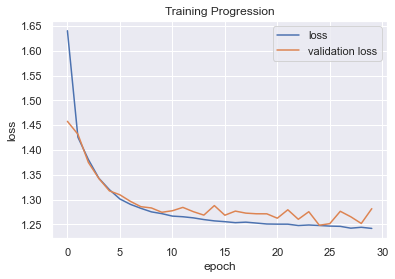

The loss on test data is 1.22, suggesting that introducing new data doesn't drastically harm loss. We can now move from looking at the results probabilistically and shift to an analysis of the classification results. The output of the model will provide an estimate the probability of each pitch type occurring, and the type with the highest probability can be taken as the predicted class. By this method of classification the model achieved 46.0% accuracy on the set-up pitch and 47.9% accuracy on the result pitch in the test set. As a baseline of comparison, four-seam fastballs were actually thrown at a rate of 35.5% and 35.1% on setup and result pitches respectively. Confusion matrices can be seen below:

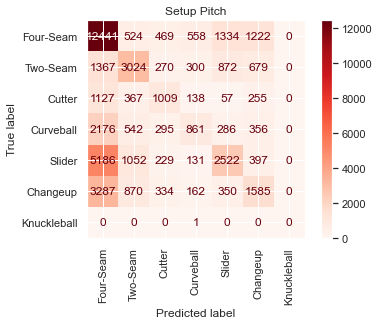

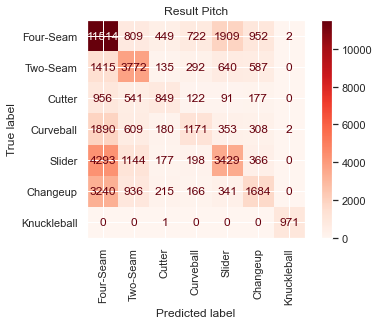

The classification task is imbalanced to a degree because some classes appear more frequently than others. Four-seam fastballs are unsurprisingly the most common pitch. To analyze diagnostic accuracy on less frequently thrown pitches, we present Receiver Operator Characteristic plots with accompanying AUC scores -- the higher those numbers are, the better. The micro-average is really a weighted average of individual plots for each class and since there is imbalance, more weight is given to prominent pitches like four-seam fastballs. The macro-average is just a straight average of the other curves. This causes the macro-average to be skewed since only two knuckleballs were thrown in the entire test set (proceed with caution when using ROC-AUC plots in the multi-class case). The four-seam fastball may be the most difficult to classify  by AUC metrics because it is often the "default" choice of the model; it's a pitch commonly thrown in many different situations compared to specialty pitches that are thrown in certain counts or as part of a particular sequence, and thus fastballs end up with more false positives.  

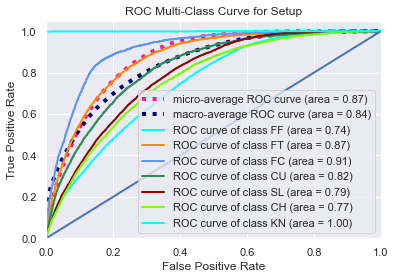

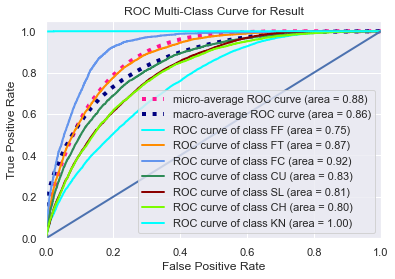

We can also see how hitters perform when a pitcher is being predictable. The resulting wOBA for each of the four situations our model may find itself in are seen below. If the model was able to predict what a pitcher would do on both pitches then hitters seemed to be more successful than getting both pitches wrong. It could be that the sequence the model is best at recognizing is fastball-fastball, and perhaps hitters naturally achieve better results in those plate appearances.

| Setup Pitch | Result Pitch | Num. of PA | wOBA |
| --- | --- | --- | --- |
| Correct | Correct | 11162 |.321 |
| Incorrect | Correct | 11154 | .316 |
| Correct | Incorrect | 10280 | .289 |
| Incorrect | Incorrect | 14039 | .292 |

## Conclusion

There are real benefits to considering plate appearances as a sequence of events rather than isolated pitches occurring in a vacuum. The possibilities of a sequence-to-sequence approach can be seen in the results displayed in this brief study. Stronger results would likely be possible if more variables were included; most inputs in this study were basic descriptors of the game situation. The drawbacks to working in the realm of deep learning (increased computation time and a necessity for large volumes of data) are worth overcoming if we truly want to know how a pitcher works strategically. The classification prowess will obviously vary from one pitcher to another, but the model herein shows promise in capturing the underlying decisions that pitchers make. Further research can be done to apply it to pitchers without extensive major league pitching history to determine how well it generalizes to new players. 

All relevant code for this exercise can be found [here](https://github.com/jmorehouse93/Baseball/blob/SequenceForecast/PitchSequenceForecast.py).